# Exploratory analysis of lateral buds

## Frequency tables
- AIM1:create a frequency table per each class length
- AIM2:create a frequency table per each shoot type (prol/syl)
- AIM3: create a frequency table per rank node IN SYLLEPTIC

## Proleptic shoot type
- AIM1: discover where are sylleptic shoots (metamer level)
- AIM2: NB of observations (buds + sylleptic shoots) in proleptic 1yo shoots per CLASS LENGHT
- AIM3: NB of observations (buds + sylleptic shoots) in proleptic 1yo shoots per RANK
- AIM4: multiple buds in proleptic 1yo shoots per RANK

data=shoots found in 2021 (Deruta)
Phd=Francesca Grisafi

## Frequency tables

### AIM1:create a frequency table per each class length

In [1]:
%run ../Modify_dataset/IMPORT_DATASET.ipynb

In [6]:
import pandas as pd

def freq_table_class_length(bud_df:pd.DataFrame, class_column: str, fate_column: str,
                           class_new_shoot_col: str, nb_new_shoots_col: str, shoot_id_col: str):
    class_length = pd.DataFrame()

    # Itera per ogni classe unica in `bud`.
    for i in bud_df[class_column].unique():
        class_buds = {}
        class_newshoot = {}
        
        # Calcola la frequenza dei boccioli per ogni 'fate' all'interno della classe.
        for j in bud_df[fate_column].unique():
            class_buds[j] = len(bud_df[(bud_df[class_column] == i) & (bud_df[fate_column] == j)])
        
        # Calcola il numero di nuovi germogli per ogni classe all'interno della classe.
        for q in bud_df[class_column].unique():
            class_newshoot[f"new_shoot_{q}"] = bud_df[(bud_df[class_column] == i) & (bud_df[class_new_shoot_col] == q)][nb_new_shoots_col].sum(skipna=True)
        
        # Aggiunge i risultati al DataFrame `class_length`.
        row_data = {'nb_shoots': bud_df[bud_df[class_column] == i][shoot_id_col].nunique(),
                    'tot_buds_m_v_b_c': len(bud_df[bud_df[class_column] == i][fate_column]),
                    'nb_new_shoots': bud_df[bud_df[class_column] == i][nb_new_shoots_col].sum(),
                    **class_buds,
                    **class_newshoot}
        
        # Crea un DataFrame temporaneo con i risultati per la classe corrente e lo appende a `class_length`.
        temp_df = pd.DataFrame([row_data], index=[i])
        class_length = pd.concat([class_length, temp_df])
    
    return class_length

class_length = freq_table_class_length(bud, "class", "fate", "length_newshoots",
                                      "nb_new_shoots", "shoot_ID")
print(class_length)


     nb_shoots  tot_buds_m_v_b_c  nb_new_shoots    V   B   C    M  \
VLo         25               671            442  284  33  71  283   
Lo          28               577            348  212  36  88  241   
Me          25               296            133   92  37  48  119   
Sh          26               133             65   55  18  24   36   

     new_shoot_VLo  new_shoot_Lo  new_shoot_Me  new_shoot_Sh  
VLo              1             4            55           382  
Lo               0             1            23           324  
Me               0             0             7           126  
Sh               0             0             4            61  


### AIM2:create a frequency table per each shoot type (prol/syl) 

In [43]:
def freq_table_prol_syl(bud_df:pd.DataFrame, shoot_type_col: str, fate_column: str,
                        nb_new_shoots_col: str, shoot_id_col: str):

    data_list = []
    
    # Itera per ogni classe unica in `bud`
    for i in bud_df[shoot_type_col].unique():
        data = {'shoot_type': i, 'nb_shoots': bud_df[bud_df[shoot_type_col] == i][shoot_id_col].nunique()}
        
        for j in ["M", "V"]:
            data[f'buds_from_{j}'] = len(bud_df[(bud_df[shoot_type_col] == i) & (bud_df[fate_column] == j)])
        
        for q in bud[fate_column].unique():
            data[f'new_shoot_from_{q}'] = bud_df[(bud_df[shoot_type_col] == i) & (bud_df[fate_column] == q)][nb_new_shoots_col].sum(skipna=True)
        
        data[nb_new_shoots_col] = bud_df[bud_df[shoot_type_col] == i][nb_new_shoots_col].sum()
        
        # Aggiunge i dati raccolti alla lista
        data_list.append(data)
    
    # Converti la lista in DataFrame
    shoot_type_summary = pd.DataFrame(data_list)
    
    # Calcola le proporzioni di "bud burst" e "errors"
    shoot_type_summary['bud_burst'] = (shoot_type_summary['new_shoot_from_M'] + shoot_type_summary['new_shoot_from_V']) / (shoot_type_summary['buds_from_M'] + shoot_type_summary['buds_from_V'])
    shoot_type_summary['errors'] = (shoot_type_summary['new_shoot_from_C'] + shoot_type_summary['new_shoot_from_B']) / shoot_type_summary['nb_new_shoots']
    
    return(shoot_type_summary)


shoot_type_summary = freq_table_prol_syl(bud, "shoot_type", "fate",
                                         "nb_new_shoots", "shoot_ID")
print(shoot_type_summary)

  shoot_type  nb_shoots  buds_from_M  buds_from_V  new_shoot_from_V  \
0  PROLEPTIC        104          429          371               281   
1  SYLLEPTIC         88          250          272               165   

   new_shoot_from_B  new_shoot_from_C  new_shoot_from_M  nb_new_shoots  \
0                24                 0               379            684   
1                 0                23               116            304   

   bud_burst    errors  
0   0.825000  0.035088  
1   0.538314  0.075658  


### AIM3: create a frequency table per each rank node IN SYLLEPTIC

In [29]:
def freq_buds_in_rank_sylleptic(metamer_syl_df: pd.DataFrame, rank_node_col: str,
                                c_col: str, v_col: str, m_col: str, b_col: str) -> pd.DataFrame:
    """
    Calcola la frequenza dei germogli silleptici per ogni rango nodale.

    Parametri:
    - metamer_syl_df (pd.DataFrame): DataFrame contenente i dati sui metameri.
    - rank_node_col (str): Nome della colonna che identifica il rango del nodo.
    - c_col (str): Nome della colonna per i conteggi di germogli 'c'.
    - v_col (str): Nome della colonna per i conteggi di germogli 'v'.
    - m_col (str): Nome della colonna per i conteggi di germogli 'm'.
    - b_col (str): Nome della colonna per i conteggi di germogli 'b'.

    Ritorna:
    pd.DataFrame: DataFrame riepilogativo con le frequenze dei germogli per rango nodale.
    """
    
    nline = len(metamer_syl_df[rank_node_col].unique())
    tab_syl = pd.DataFrame(index=np.arange(1, nline + 1),
                           columns=['rank_node', 'nb_shoots', c_col, v_col, m_col, b_col])

    for q, Q in enumerate(sorted(metamer_syl_df[rank_node_col].unique()), 1):
        subset = metamer_syl_df[metamer_syl_df[rank_node_col] == Q]
        tab_syl.loc[q, 'rank_node'] = Q
        tab_syl.loc[q, 'nb_shoots'] = len(subset)
        tab_syl.loc[q, c_col] = subset[c_col].sum()
        tab_syl.loc[q, v_col] = subset[v_col].sum()
        tab_syl.loc[q, m_col] = subset[m_col].sum()
        tab_syl.loc[q, b_col] = subset[b_col].sum()

    # Aggiungere la somma per ogni colonna e per ogni riga
    tab_syl.loc['sums', [c_col, v_col, m_col, b_col]] = tab_syl[[c_col, v_col, m_col, b_col]].sum()
    tab_syl['sums'] = tab_syl[[c_col, v_col, m_col, b_col]].sum(axis=1)

    #relative frequence
    for col in [c_col, v_col, m_col, b_col]:
        tab_syl[f'%{col.upper()}'] = (tab_syl[col].astype(float) / tab_syl['nb_shoots'].astype(float) * 100).round(2)

    return tab_syl

tab_syl = freq_buds_in_rank_sylleptic(met_sylleptic, 'parent_rank_node', 'c_syl', 'v_syl', 'm_syl', 'b')
print(tab_syl.head())

  rank_node nb_shoots c_syl v_syl m_syl  b sums  %C_SYL  %V_SYL  %M_SYL   %B
1         1         3     3     0     0  0    3   100.0    0.00    0.00  0.0
2         2        11    11     8     9  0   28   100.0   72.73   81.82  0.0
3         3        19    19    21    12  0   52   100.0  110.53   63.16  0.0
4         4        25    25    29    21  0   75   100.0  116.00   84.00  0.0
5         5        46    46    66    69  0  181   100.0  143.48  150.00  0.0


## PROLEPTIC SHOOT TYPE

### AIM1: discover where are sylleptic shoots (metamer level)

In [35]:
import matplotlib.pyplot as plt

print(met_proleptic.columns)

def plot_scatter(df, x_col, y_col, title):
    plt.scatter(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

Index(['tesi', 'unit', 'length', 'unit_2', 'diam', 'class', 'shoot_ID', 'tree',
       'Length(node)', 'rank_node', 'median_distance', 'norm_median_distance',
       'abs_norm_median_distance', 'abs_median_distance', 'sylleptic', 'v',
       'm', 'cl', 'nu', 'b', 'tot_buds_mvb', 'tot_buds_mv', 'shoot_type',
       'nb_new_shoots', 'c_syl', 'v_syl', 'm_syl', 'tot_buds_syl_m_v',
       'tot_buds_m_v_b_c'],
      dtype='object')


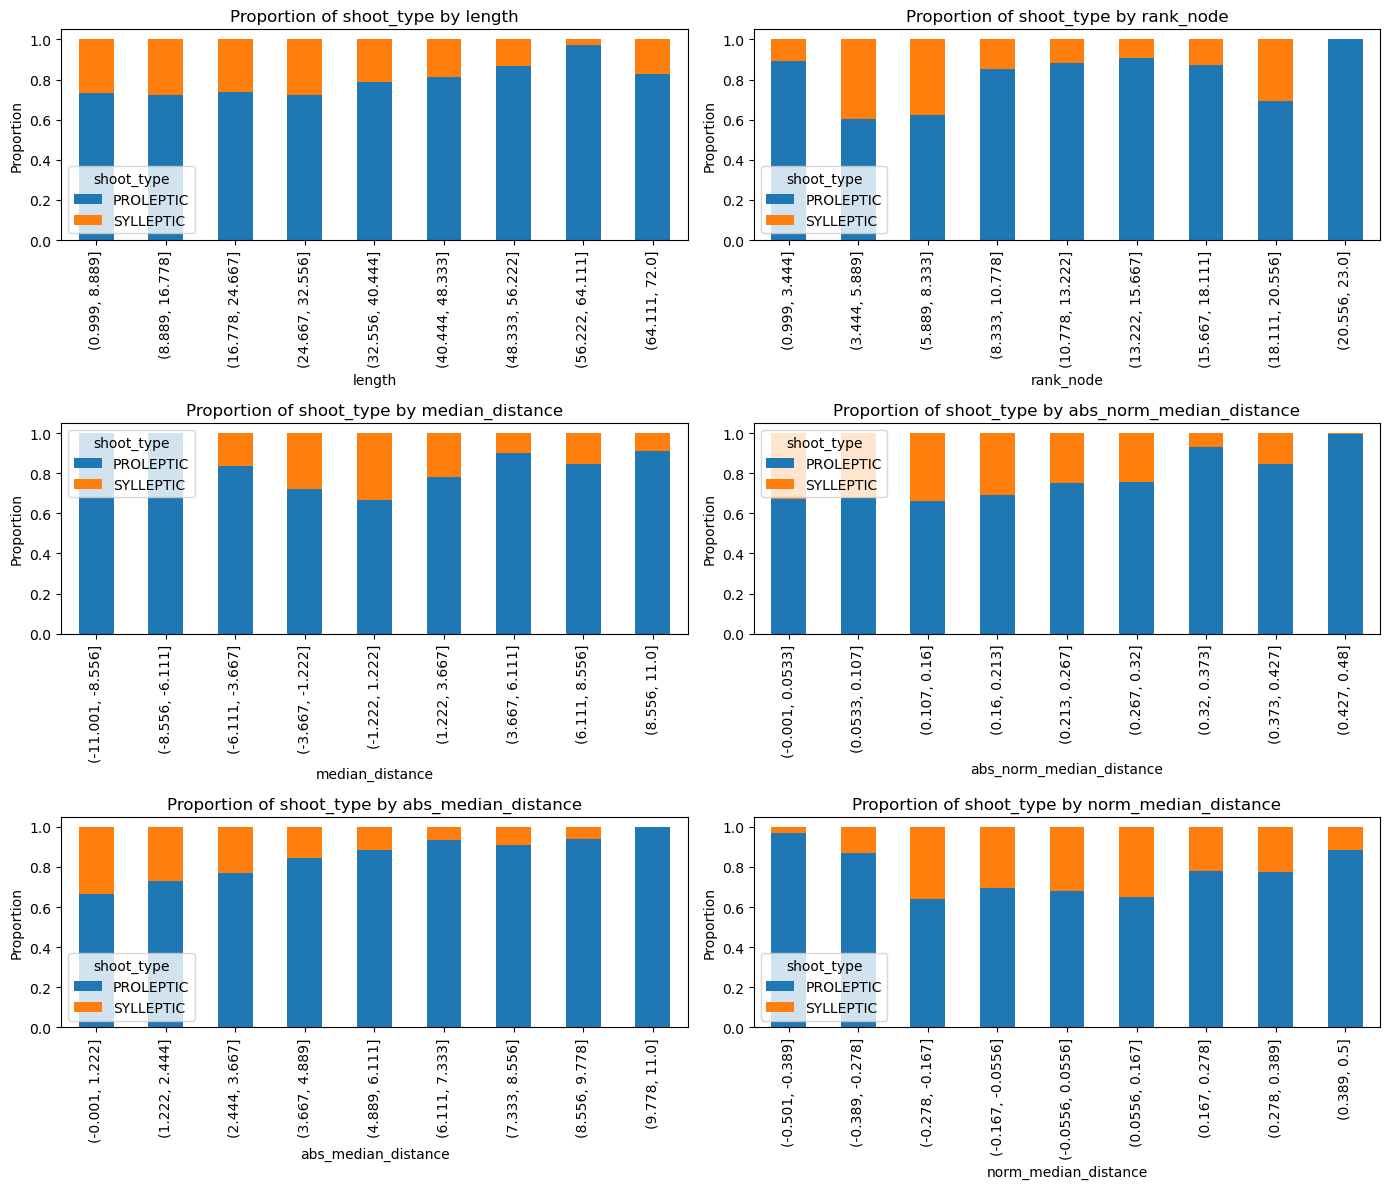

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Supponiamo che met_proleptic sia il DataFrame e che contenga una colonna 'shoot_type' categorica
# e diverse colonne continue come 'length', 'rank_node', ecc.

def plot_proportion(df, x_var, cat_var, ax, num_bins=10):
    # Bin the continuous variable
    bins = np.linspace(df[x_var].min(), df[x_var].max(), num_bins)
    df['binned'] = pd.cut(df[x_var], bins, include_lowest=True)
    
    # Calcola la proporzione per ciascun bin
    proportions = df.groupby(['binned', cat_var], observed=True).size().unstack().fillna(0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    
    # Plot
    proportions.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'Proportion of {cat_var} by {x_var}')
    ax.set_xlabel(x_var)
    ax.set_ylabel('Proportion')

# Creazione di subplot per ciascun x_var
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
x_vars = ['length', 'rank_node', 'median_distance', 'abs_norm_median_distance', 'abs_median_distance', 'norm_median_distance']

for ax, x_var in zip(axes.flatten(), x_vars):
    plot_proportion(met_proleptic, x_var, 'shoot_type', ax)

plt.tight_layout()
plt.show()

###  AIM2: NB of observations (buds + sylleptic shoots) in proleptic 1yo shoots per CLASS LENGHT 

In [49]:
def calculate_class_summary(df, class_col, count_cols):
    # Inizializza liste per raccogliere i dati
    data = {col: [] for col in [class_col] + count_cols}
    data['Total'] = []

    # Aggrega i dati per classe
    for i in df[class_col].unique():
        subset = df[df[class_col] == i]
        data[class_col].append(i)
        for col in count_cols:
            data[col].append(subset[col].sum())
        data['Total'].append(subset[count_cols].sum().sum())

    # Crea un DataFrame dai dati raccolti
    summary_df = pd.DataFrame(data)

    # Calcola le percentuali relative
    for col in count_cols:
        summary_df[f'%{col}'] = (summary_df[col] / summary_df['Total']) * 100

    # Calcola la somma delle colonne e delle righe se necessario
    # Aggiungi ulteriori operazioni qui...

    return summary_df

class_summary = calculate_class_summary(met_proleptic, 'class', ['sylleptic', 'v', 'm', 'b'])
print(class_summary)

  class  sylleptic    v    m   b  Total  %sylleptic         %v         %m  \
0   VLo         71  184  193  33    481   14.760915  38.253638  40.124740   
1    Lo         88  103  156  36    383   22.976501  26.892950  40.731070   
2    Me         48   44   56  37    185   25.945946  23.783784  30.270270   
3    Sh         24   40   24  18    106   22.641509  37.735849  22.641509   

          %b  
0   6.860707  
1   9.399478  
2  20.000000  
3  16.981132  
